## 02. Neural Network classification with PyTorch

Classification is a problem of predicting wheather something is one thing or another (there can be multiple things as options).



In [218]:
## 1. Make classification data and get it ready 

import sklearn
from sklearn.datasets import make_circles

# Make 1000 sample 
n_samples = 1000

# Create circles 
X, y = make_circles(n_samples,
                    noise = 0.03,        # it for randomness
                    random_state=42)     # Similar to setting the random seed



In [219]:
len(X), len(y)

(1000, 1000)

In [220]:
print(f"First 5 sample of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 sample of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [221]:
# Make  DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0], 
                        "X2": X[:, 1],
                        "label" : y})

In [222]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


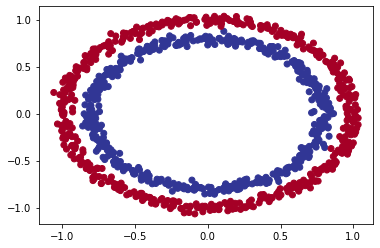

In [223]:
# Visualize 
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

## Check input and output shapes

In [224]:
X.shape, y.shape

((1000, 2), (1000,))

In [225]:
# View the first example of feature and lables
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shapes for one sample of X: {X_sample.shape} and same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
shapes for one sample of X: (2,) and same for y: ()


In [226]:
# Turn data into Tensors
import torch 
torch.__version__

'1.11.0+cu113'

In [227]:
X = torch.from_numpy(X).type(torch.float)  # we want our datatype of tensor to be float32 but converting from numpy to tensor is by default is float64
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [228]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [229]:
# Split data into training and test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42) 

In [230]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (subclassing `nn.module`)
3. Define a loss function and optimizer
4. Create a training and test loop 

In [231]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [232]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.module` (almost all models in PyTorch subclass `nn.module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data 
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [233]:
# 1.Construct a model that subclasses nn.Module 
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features= 2, out_features=5)  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features= 5, out_features=1)  # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. define a forward()  method that outlines the forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device 
model_0 = CircleModelV0().to(device)


In [234]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [235]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### 2.1 Setup a loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific 

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).memoryview

For classification you might want binary cross entropy or categorical cross entropy

As a reaminder, loss function measures how your model is performing.

And for optimizers, two of the most common are SGD and Adam, however PyTorch has built in options.

* For a loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [236]:
# Setup the loss function 
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss() = sigmoid activaiton function built in

optimizer  = torch.optim.SGD(params = model_0.parameters(),
                             lr = 0.1)
                             

In [237]:
# Calculate accuracy - Out of 100 example, wht percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct  = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [238]:
# xa = torch.arange(1, 10)
# ya = torch.arange(1, 10)
# p = torch.eq(xa, ya).sum().item()
# p

 ## 3. Training a model 

 from distutils.version import LooseVersion
from turtle import backward


To train a model, we're going to need to build a training loop;

 1. Forward pass
 2. Calculate the LooseVersion
 3. Optimizer zero grad
 4. Loss backward (backpropagation)
 5. Optimizer step (Gradient descent)
 

### 3.1 Going from raw logits -> predictions probabilites -> Predictions labels 

our model outputs are going to be raw **logits**

We can convert these **logits** into predictions probabilities by passing them to some kind of activation function (e.g. sigmoid for bincary classification and softmax for multiclass classification)

Then we can convert our model's predictions probabilities to predictions labels by either rounding them or taking the argmax()

Logits are the real output of our model before passing it to any activation function

In [239]:
# View the first 5 outputs of the forwad pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits  = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [240]:
# use the sigmoid activation function on our model logits to turn them into predictions probabilities

y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

For our predictions probabilites values, we need to perform a range-style rounding on them:

* `y_preds_probs` >= 0.5, `y=1` (class 1)
* `y_preds_probs` < 0.5, `y=0` (class 0)

In [241]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check the equality 
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [242]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [243]:
# 3.2 Building a training and testing loop

torch.manual_seed(42)

# set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build the training and evaluation loop 
for epoch in range(epochs):
    ### Training 
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate the loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits)) # nn.BCELoss expects prediction probabilities as input

    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad

    # 4. loss backward (backpropgation)
    loss.backward()

    # 5. optimizer step (Gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                                y_pred = test_pred)


    # Print our what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test_loss: {test_acc: .2f}%")



Epoch: 0 | Loss: 0.69569 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 10 | Loss: 0.69439 | Accuracy: 58.63% | Test_loss:  54.50%
Epoch: 20 | Loss: 0.69299 | Accuracy: 51.50% | Test_loss:  46.50%
Epoch: 30 | Loss: 0.69481 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 40 | Loss: 0.69527 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 50 | Loss: 0.69312 | Accuracy: 42.00% | Test_loss:  50.00%
Epoch: 60 | Loss: 0.69436 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 70 | Loss: 0.69487 | Accuracy: 59.00% | Test_loss:  57.50%
Epoch: 80 | Loss: 0.69316 | Accuracy: 51.25% | Test_loss:  47.00%
Epoch: 90 | Loss: 0.69486 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 100 | Loss: 0.69328 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 110 | Loss: 0.69459 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 120 | Loss: 0.69358 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 130 | Loss: 0.69434 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch: 140 | Loss: 0.69356 | Accuracy: 50.00% | Test_loss:  50.00%
Epoch:

## 4. Make predictions and evaluate the model
 
 From the metrics it looks like our model isn't learning anything ...

 So to inspect it let's make some predictions and make the visual!

 In other words, "Visualize, Visualize, Visualize!"

 To do so, we're going to imort a functin called `plot_decision_boundary()`
 

In [244]:
import requests
from pathlib import Path

# Dlownload helper functions form learn PyTorch repo(if it's not already downloaded )
if Path("helper_function.py").is_file():
    print("helper_functions.py already exists, skipped download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content) 

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


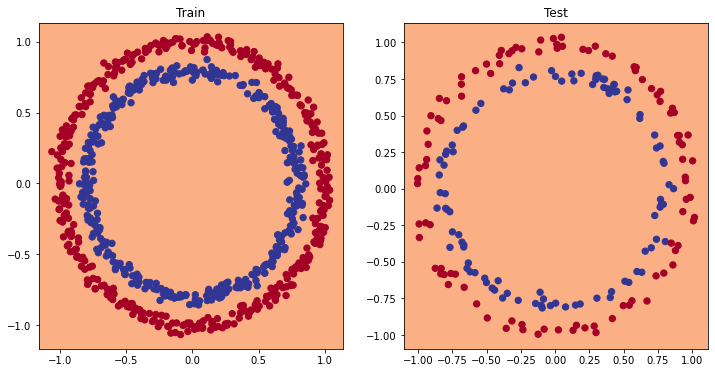

In [245]:
# Plot decision boundary of the model 
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
* These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

Let's try and improve our model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [250]:
class CircleModelV1(nn.Module):
   def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2, out_features=10 )
      self.layer_2 = nn.Linear(in_features=10, out_features=10)
      self.layer_3 = nn.Linear(in_features=10, out_features=2)
   
   def forward(self, x):
      z = self.layer_1(x)
      z = self.layer_2(z)
      z = self.layer_3(z)
      return z

model_1 = CircleModelV1().to(device)
model_1
   

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=2, bias=True)
)